<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


## Initializing the game

In [4]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 18.1 MB/s eta 0:00:00
Cloning into 'HomMul'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 85 (delta 26), reused 41 (delta 10), pack-reused 0
Unpacking objects: 100% (85/85), 2.70 MiB | 9.22 MiB/s, done.


In [5]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [6]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
#@title Setup Gymnasium environment
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 0
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: wait
--Previous action of agent 2: wait

Episode #2
--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 1
--Current life of agent 1: 2
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: wait
--Previous action of agent 2: wait

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 

## Heuristics Benchmarking


death rate of player2: 0.317
ratio of death rate of player2 with respect to player1: 0.878


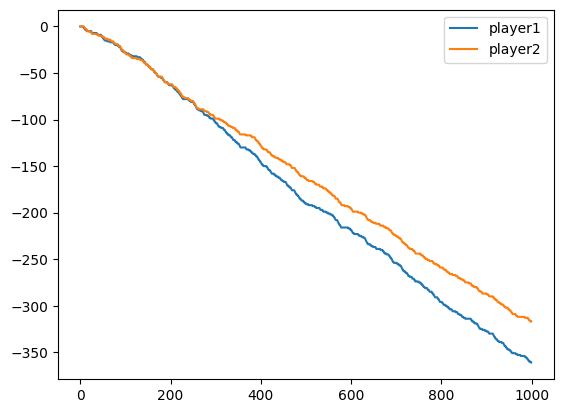

In [9]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.421
ratio of death rate of player2 with respect to player1: 0.651


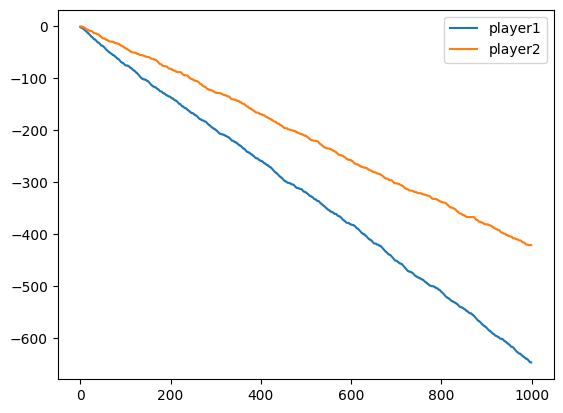

In [10]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.564
ratio of death rate of player2 with respect to player1: 0.861


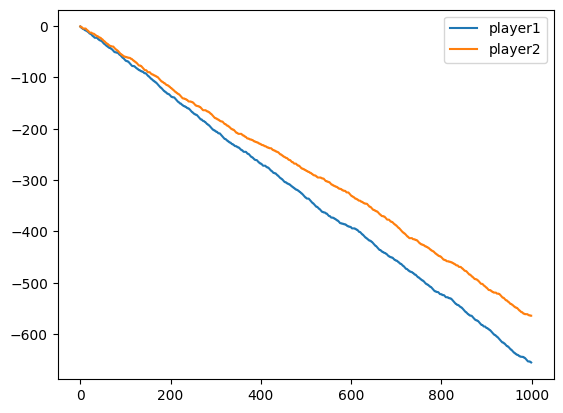

In [11]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.428
ratio of death rate of player2 with respect to player1: 0.672


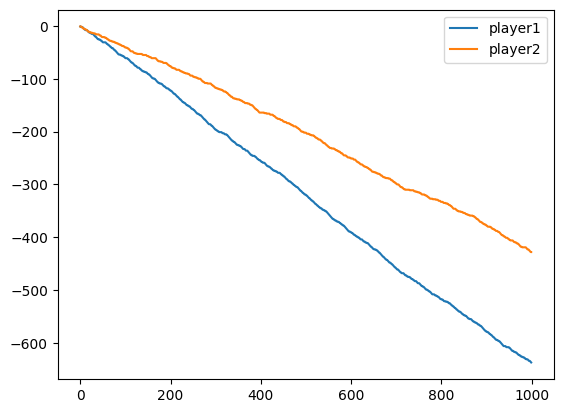

In [12]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.402
ratio of death rate of player2 with respect to player1: 0.775


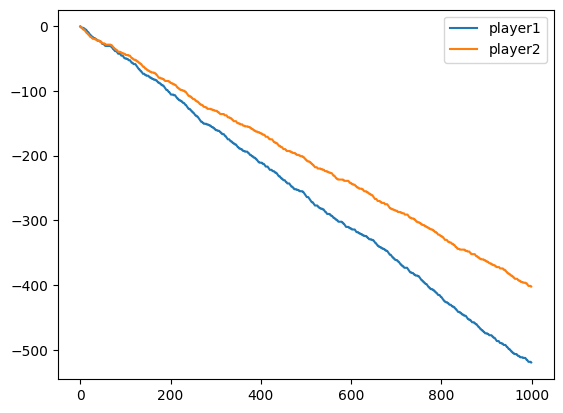

In [13]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.518
ratio of death rate of player2 with respect to player1: 0.818


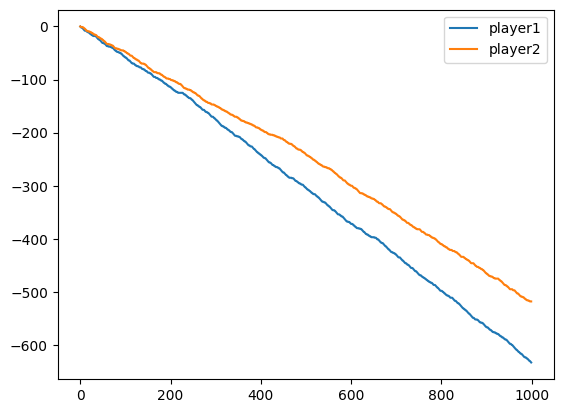

In [14]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.213
ratio of death rate of player2 with respect to player1: 0.372


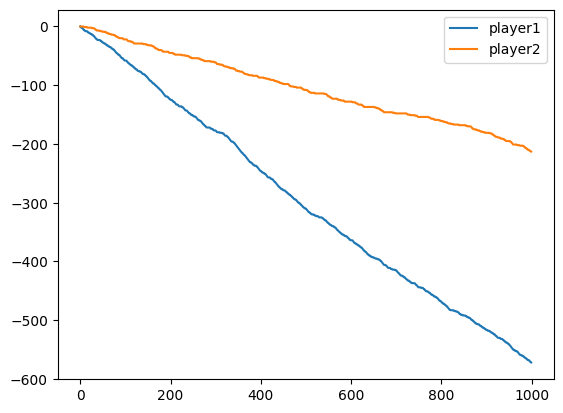

In [15]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.299
ratio of death rate of player2 with respect to player1: 0.466


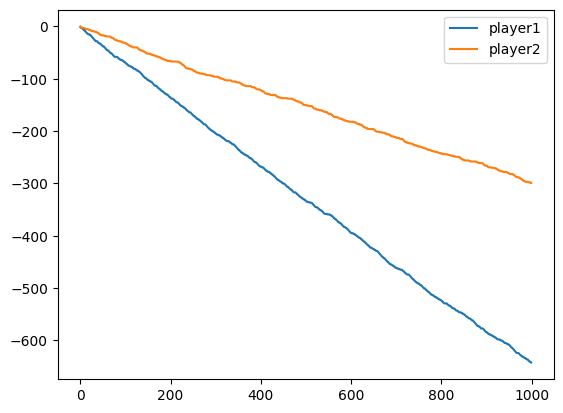

In [16]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [17]:
#@title Load optimal policy

def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

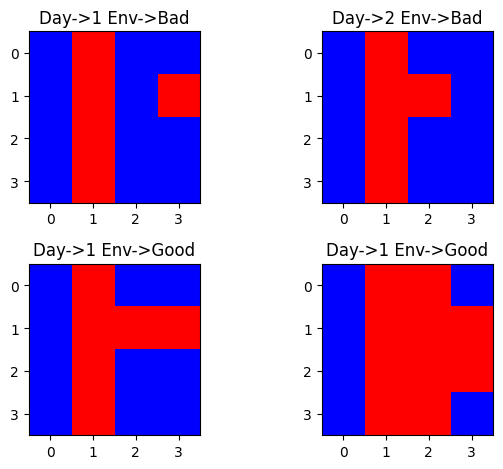

In [18]:
#@title Visualize optimal policy

df = pd.read_csv("models/optimal_policy.csv")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[(df["days_left"] == 1) & (df["player1_prob_payoff"] < 0.3), "action"].values
arr = np.insert(arr, 0, 1, axis=0)

ax1.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
ax1.set_title("Day->1 Env->Bad")

arr = df.loc[(df["days_left"] == 2) & (df["player1_prob_payoff"] < 0.3), "action"].values
arr = np.insert(arr, 0, 1, axis=0)

ax2.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
ax2.set_title("Day->2 Env->Bad")

arr = df.loc[(df["days_left"] == 1) & (df["player1_prob_payoff"] > 0.3), "action"].values
arr = np.insert(arr, 0, 1, axis=0)

ax3.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
ax3.set_title("Day->1 Env->Good")

arr = df.loc[(df["days_left"] == 2) & (df["player1_prob_payoff"] > 0.3), "action"].values
arr = np.insert(arr, 0, 1, axis=0)

ax4.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
ax4.set_title("Day->1 Env->Good")

fig.tight_layout()
plt.show()

death rate of player2: 0.255
ratio of death rate of player2 with respect to player1: 0.489


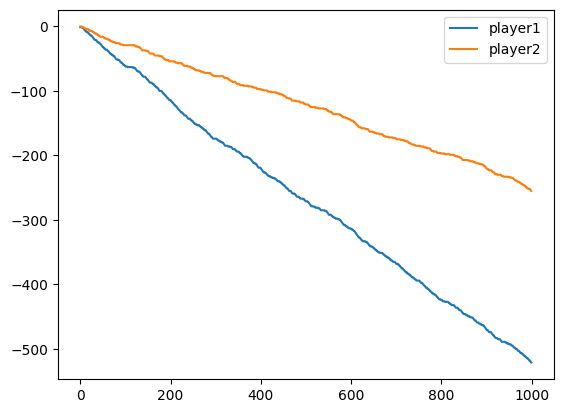

In [19]:
#@title Case - hail mary vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.351
ratio of death rate of player2 with respect to player1: 0.563


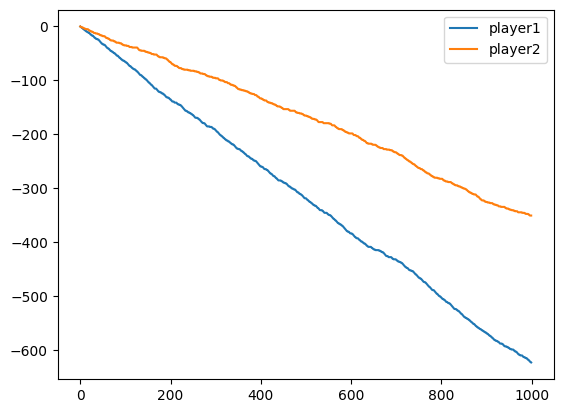

In [20]:
#@title Case - Always wait vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.190
ratio of death rate of player2 with respect to player1: 0.408


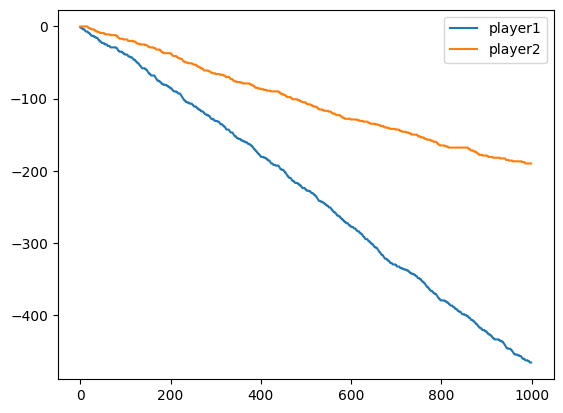

In [21]:
#@title Case - Always play vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

## Deep RL training


In [22]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [35]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=True)
agent_learn2 = _get_agent(pretrained=True)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= -0.1

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [37]:
#@title Training
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:01, 664.52it/s, env_step=1000, len=2, n/ep=19, n/st=50, player1/loss=0.316, player2/loss=0.352, rew=-0.32]                          


Epoch #1: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #1


Epoch #2: 1001it [00:01, 597.43it/s, env_step=2000, len=2, n/ep=18, n/st=50, player1/loss=0.304, player2/loss=0.398, rew=-0.28]                          


Epoch #2: test_reward: -0.190000 ± 0.392301, best_reward: -0.170000 ± 0.375633 in #1


Epoch #3: 1001it [00:01, 782.80it/s, env_step=3000, len=3, n/ep=16, n/st=50, player1/loss=0.302, player2/loss=0.407, rew=-0.19]                          


Epoch #3: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #1


Epoch #4: 1001it [00:01, 785.20it/s, env_step=4000, len=2, n/ep=20, n/st=50, player1/loss=0.256, player2/loss=0.398, rew=-0.10]                          


Epoch #4: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #1


Epoch #5: 1001it [00:01, 783.23it/s, env_step=5000, len=2, n/ep=20, n/st=50, player1/loss=0.285, player2/loss=0.405, rew=-0.30]                          


Epoch #5: test_reward: -0.230000 ± 0.420833, best_reward: -0.170000 ± 0.375633 in #1


Epoch #6: 1001it [00:01, 765.98it/s, env_step=6000, len=2, n/ep=18, n/st=50, player1/loss=0.279, player2/loss=0.378, rew=-0.17]                          


Epoch #6: test_reward: -0.250000 ± 0.433013, best_reward: -0.170000 ± 0.375633 in #1


Epoch #7: 1001it [00:01, 774.02it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.252, player2/loss=0.435, rew=-0.33]                          


Epoch #7: test_reward: -0.180000 ± 0.384187, best_reward: -0.170000 ± 0.375633 in #1


Epoch #8: 1001it [00:01, 652.14it/s, env_step=8000, len=3, n/ep=15, n/st=50, player1/loss=0.268, player2/loss=0.411, rew=-0.20]                          


Epoch #8: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #1


Epoch #9: 1001it [00:01, 604.02it/s, env_step=9000, len=2, n/ep=18, n/st=50, player1/loss=0.279, player2/loss=0.444, rew=-0.11]                          


Epoch #9: test_reward: -0.150000 ± 0.357071, best_reward: -0.150000 ± 0.357071 in #9


Epoch #10: 1001it [00:01, 735.03it/s, env_step=10000, len=2, n/ep=19, n/st=50, player1/loss=0.321, player2/loss=0.402, rew=-0.21]                          


Epoch #10: test_reward: -0.130000 ± 0.336303, best_reward: -0.130000 ± 0.336303 in #10


Epoch #11: 1001it [00:01, 767.95it/s, env_step=11000, len=3, n/ep=17, n/st=50, player1/loss=0.298, player2/loss=0.408, rew=-0.12]                          


Epoch #11: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #10


Epoch #12: 1001it [00:01, 767.30it/s, env_step=12000, len=3, n/ep=17, n/st=50, player1/loss=0.283, player2/loss=0.464, rew=-0.18]                          


Epoch #12: test_reward: -0.270000 ± 0.443959, best_reward: -0.130000 ± 0.336303 in #10


Epoch #13: 1001it [00:01, 748.82it/s, env_step=13000, len=3, n/ep=18, n/st=50, player1/loss=0.303, player2/loss=0.463, rew=-0.22]                          


Epoch #13: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #14: 1001it [00:01, 767.15it/s, env_step=14000, len=3, n/ep=16, n/st=50, player1/loss=0.350, player2/loss=0.479, rew=-0.31]                          


Epoch #14: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #10


Epoch #15: 1001it [00:01, 605.95it/s, env_step=15000, len=2, n/ep=17, n/st=50, player1/loss=0.350, player2/loss=0.495, rew=-0.35]                          


Epoch #15: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #16: 1001it [00:01, 632.42it/s, env_step=16000, len=2, n/ep=15, n/st=50, player1/loss=0.342, player2/loss=0.512, rew=-0.33]                          


Epoch #16: test_reward: -0.180000 ± 0.384187, best_reward: -0.130000 ± 0.336303 in #10


Epoch #17: 1001it [00:01, 775.15it/s, env_step=17000, len=2, n/ep=19, n/st=50, player1/loss=0.355, player2/loss=0.523, rew=-0.16]                          


Epoch #17: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #18: 1001it [00:01, 767.88it/s, env_step=18000, len=2, n/ep=19, n/st=50, player1/loss=0.343, player2/loss=0.510, rew=-0.16]                          


Epoch #18: test_reward: -0.170000 ± 0.375633, best_reward: -0.130000 ± 0.336303 in #10


Epoch #19: 1001it [00:01, 757.17it/s, env_step=19000, len=3, n/ep=16, n/st=50, player1/loss=0.357, player2/loss=0.521, rew=-0.19]                          


Epoch #19: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #10


Epoch #20: 1001it [00:01, 762.58it/s, env_step=20000, len=2, n/ep=18, n/st=50, player1/loss=0.385, player2/loss=0.482, rew=-0.33]                          


Epoch #20: test_reward: -0.280000 ± 0.448999, best_reward: -0.130000 ± 0.336303 in #10


Epoch #21: 1001it [00:01, 528.54it/s, env_step=21000, len=3, n/ep=16, n/st=50, player1/loss=0.361, player2/loss=0.465, rew=-0.19]                          


Epoch #21: test_reward: -0.150000 ± 0.357071, best_reward: -0.130000 ± 0.336303 in #10


Epoch #22: 1001it [00:01, 549.18it/s, env_step=22000, len=2, n/ep=17, n/st=50, player1/loss=0.332, player2/loss=0.551, rew=-0.24]                          


Epoch #22: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #10


Epoch #23: 1001it [00:01, 753.27it/s, env_step=23000, len=2, n/ep=18, n/st=50, player1/loss=0.354, player2/loss=0.479, rew=-0.28]                          


Epoch #23: test_reward: -0.170000 ± 0.375633, best_reward: -0.130000 ± 0.336303 in #10


Epoch #24: 1001it [00:01, 751.98it/s, env_step=24000, len=2, n/ep=18, n/st=50, player1/loss=0.380, player2/loss=0.491, rew=-0.06]                          


Epoch #24: test_reward: -0.250000 ± 0.433013, best_reward: -0.130000 ± 0.336303 in #10


Epoch #25: 1001it [00:01, 773.81it/s, env_step=25000, len=3, n/ep=15, n/st=50, player1/loss=0.418, player2/loss=0.515, rew=-0.20]                          


Epoch #25: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #26: 1001it [00:01, 782.95it/s, env_step=26000, len=2, n/ep=20, n/st=50, player1/loss=0.390, player2/loss=0.549, rew=-0.25]                          


Epoch #26: test_reward: -0.200000 ± 0.400000, best_reward: -0.130000 ± 0.336303 in #10


Epoch #27: 1001it [00:01, 781.06it/s, env_step=27000, len=3, n/ep=16, n/st=50, player1/loss=0.410, player2/loss=0.548, rew=-0.06]                          


Epoch #27: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #28: 1001it [00:01, 755.59it/s, env_step=28000, len=2, n/ep=17, n/st=50, player1/loss=0.408, player2/loss=0.584, rew=-0.47]                          


Epoch #28: test_reward: -0.260000 ± 0.438634, best_reward: -0.130000 ± 0.336303 in #10


Epoch #29: 1001it [00:01, 586.49it/s, env_step=29000, len=2, n/ep=17, n/st=50, player1/loss=0.414, player2/loss=0.623, rew=-0.35]                          


Epoch #29: test_reward: -0.200000 ± 0.400000, best_reward: -0.130000 ± 0.336303 in #10


Epoch #30: 1001it [00:01, 791.91it/s, env_step=30000, len=2, n/ep=17, n/st=50, player1/loss=0.449, player2/loss=0.545, rew=-0.18]                          


Epoch #30: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #31: 1001it [00:01, 781.26it/s, env_step=31000, len=2, n/ep=17, n/st=50, player1/loss=0.414, player2/loss=0.558, rew=-0.12]                          


Epoch #31: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #32: 1001it [00:01, 784.10it/s, env_step=32000, len=2, n/ep=19, n/st=50, player1/loss=0.405, player2/loss=0.630, rew=-0.21]                          


Epoch #32: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #33: 1001it [00:01, 760.57it/s, env_step=33000, len=3, n/ep=15, n/st=50, player1/loss=0.431, player2/loss=0.617, rew=-0.33]                          


Epoch #33: test_reward: -0.180000 ± 0.384187, best_reward: -0.130000 ± 0.336303 in #10


Epoch #34: 1001it [00:01, 765.97it/s, env_step=34000, len=2, n/ep=17, n/st=50, player1/loss=0.440, player2/loss=0.576, rew=-0.35]                          


Epoch #34: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #10


Epoch #35: 1001it [00:01, 696.76it/s, env_step=35000, len=2, n/ep=21, n/st=50, player1/loss=0.402, player2/loss=0.559, rew=-0.24]                          


Epoch #35: test_reward: -0.290000 ± 0.453762, best_reward: -0.130000 ± 0.336303 in #10


Epoch #36: 1001it [00:01, 594.31it/s, env_step=36000, len=3, n/ep=17, n/st=50, player1/loss=0.464, player2/loss=0.616, rew=-0.06]                          


Epoch #36: test_reward: -0.170000 ± 0.375633, best_reward: -0.130000 ± 0.336303 in #10


Epoch #37: 1001it [00:01, 778.91it/s, env_step=37000, len=3, n/ep=15, n/st=50, player1/loss=0.435, player2/loss=0.683, rew=-0.27]                          


Epoch #37: test_reward: -0.290000 ± 0.453762, best_reward: -0.130000 ± 0.336303 in #10


Epoch #38: 1001it [00:01, 756.68it/s, env_step=38000, len=3, n/ep=16, n/st=50, player1/loss=0.423, player2/loss=0.595, rew=-0.44]                          


Epoch #38: test_reward: -0.280000 ± 0.448999, best_reward: -0.130000 ± 0.336303 in #10


Epoch #39: 1001it [00:01, 767.54it/s, env_step=39000, len=2, n/ep=18, n/st=50, player1/loss=0.475, player2/loss=0.635, rew=-0.22]                          


Epoch #39: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #40: 1001it [00:01, 765.14it/s, env_step=40000, len=2, n/ep=17, n/st=50, player1/loss=0.475, player2/loss=0.657, rew=-0.29]                          


Epoch #40: test_reward: -0.200000 ± 0.400000, best_reward: -0.130000 ± 0.336303 in #10


Epoch #41: 1001it [00:01, 743.70it/s, env_step=41000, len=3, n/ep=17, n/st=50, player1/loss=0.467, player2/loss=0.690, rew=-0.24]                          


Epoch #41: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #10


Epoch #42: 1001it [00:01, 693.72it/s, env_step=42000, len=2, n/ep=17, n/st=50, player1/loss=0.482, player2/loss=0.614, rew=-0.06]                          


Epoch #42: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #43: 1001it [00:01, 562.74it/s, env_step=43000, len=2, n/ep=17, n/st=50, player1/loss=0.478, player2/loss=0.695, rew=-0.24]                          


Epoch #43: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #44: 1001it [00:01, 757.48it/s, env_step=44000, len=2, n/ep=17, n/st=50, player1/loss=0.486, player2/loss=0.670, rew=-0.18]                          


Epoch #44: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #10


Epoch #45: 1001it [00:01, 784.85it/s, env_step=45000, len=3, n/ep=17, n/st=50, player1/loss=0.435, player2/loss=0.646, rew=-0.18]                          


Epoch #45: test_reward: -0.180000 ± 0.384187, best_reward: -0.130000 ± 0.336303 in #10


Epoch #46: 1001it [00:01, 783.94it/s, env_step=46000, len=2, n/ep=17, n/st=50, player1/loss=0.465, player2/loss=0.654, rew=-0.24]                          


Epoch #46: test_reward: -0.280000 ± 0.448999, best_reward: -0.130000 ± 0.336303 in #10


Epoch #47: 1001it [00:01, 769.67it/s, env_step=47000, len=3, n/ep=16, n/st=50, player1/loss=0.484, player2/loss=0.732, rew=0.00]                          


Epoch #47: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #10


Epoch #48: 1001it [00:01, 782.52it/s, env_step=48000, len=3, n/ep=17, n/st=50, player1/loss=0.441, player2/loss=0.684, rew=-0.24]                          


Epoch #48: test_reward: -0.270000 ± 0.443959, best_reward: -0.130000 ± 0.336303 in #10


Epoch #49: 1001it [00:01, 691.53it/s, env_step=49000, len=2, n/ep=18, n/st=50, player1/loss=0.505, player2/loss=0.687, rew=-0.28]                          


Epoch #49: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #50: 1001it [00:01, 594.19it/s, env_step=50000, len=2, n/ep=18, n/st=50, player1/loss=0.425, player2/loss=0.684, rew=-0.11]                          


Epoch #50: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #10


Epoch #51: 1001it [00:01, 791.60it/s, env_step=51000, len=3, n/ep=17, n/st=50, player1/loss=0.471, player2/loss=0.737, rew=-0.29]                          


Epoch #51: test_reward: -0.130000 ± 0.336303, best_reward: -0.130000 ± 0.336303 in #10


Epoch #52: 1001it [00:01, 776.20it/s, env_step=52000, len=3, n/ep=17, n/st=50, player1/loss=0.467, player2/loss=0.641, rew=-0.29]                          


Epoch #52: test_reward: -0.290000 ± 0.453762, best_reward: -0.130000 ± 0.336303 in #10


Epoch #53: 1001it [00:01, 754.29it/s, env_step=53000, len=3, n/ep=16, n/st=50, player1/loss=0.477, player2/loss=0.657, rew=-0.12]                          


Epoch #53: test_reward: -0.260000 ± 0.438634, best_reward: -0.130000 ± 0.336303 in #10


Epoch #54: 1001it [00:01, 763.47it/s, env_step=54000, len=2, n/ep=17, n/st=50, player1/loss=0.443, player2/loss=0.733, rew=-0.29]                          


Epoch #54: test_reward: -0.160000 ± 0.366606, best_reward: -0.130000 ± 0.336303 in #10


Epoch #55: 1001it [00:01, 778.11it/s, env_step=55000, len=2, n/ep=17, n/st=50, player1/loss=0.445, player2/loss=0.757, rew=-0.12]                          


Epoch #55: test_reward: -0.300000 ± 0.458258, best_reward: -0.130000 ± 0.336303 in #10


Epoch #56: 1001it [00:01, 693.61it/s, env_step=56000, len=2, n/ep=18, n/st=50, player1/loss=0.461, player2/loss=0.737, rew=-0.11]                          


Epoch #56: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #10


Epoch #57: 1001it [00:01, 596.14it/s, env_step=57000, len=3, n/ep=16, n/st=50, player1/loss=0.485, player2/loss=0.719, rew=-0.25]                          


Epoch #57: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #10


Epoch #58: 1001it [00:01, 755.52it/s, env_step=58000, len=2, n/ep=20, n/st=50, player1/loss=0.458, player2/loss=0.776, rew=-0.30]                          


Epoch #58: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #10


Epoch #59: 1001it [00:01, 758.18it/s, env_step=59000, len=3, n/ep=15, n/st=50, player1/loss=0.506, player2/loss=0.782, rew=-0.40]                          


Epoch #59: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #10


Epoch #60: 1001it [00:01, 775.63it/s, env_step=60000, len=3, n/ep=17, n/st=50, player1/loss=0.472, player2/loss=0.813, rew=-0.24]                          


Epoch #60: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #10


Epoch #61: 1001it [00:01, 755.21it/s, env_step=61000, len=3, n/ep=16, n/st=50, player1/loss=0.469, player2/loss=0.833, rew=-0.31]                          


Epoch #61: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #62: 1001it [00:01, 754.96it/s, env_step=62000, len=2, n/ep=17, n/st=50, player1/loss=0.499, player2/loss=0.804, rew=-0.29]                          


Epoch #62: test_reward: -0.190000 ± 0.392301, best_reward: -0.130000 ± 0.336303 in #10


Epoch #63: 1001it [00:01, 639.80it/s, env_step=63000, len=2, n/ep=17, n/st=50, player1/loss=0.471, player2/loss=0.733, rew=-0.29]                          


Epoch #63: test_reward: -0.270000 ± 0.443959, best_reward: -0.130000 ± 0.336303 in #10


Epoch #64: 1001it [00:01, 589.40it/s, env_step=64000, len=2, n/ep=17, n/st=50, player1/loss=0.509, player2/loss=0.735, rew=-0.06]                          


Epoch #64: test_reward: -0.270000 ± 0.443959, best_reward: -0.130000 ± 0.336303 in #10


Epoch #65: 1001it [00:01, 765.82it/s, env_step=65000, len=2, n/ep=18, n/st=50, player1/loss=0.509, player2/loss=0.754, rew=-0.33]                          


Epoch #65: test_reward: -0.260000 ± 0.438634, best_reward: -0.130000 ± 0.336303 in #10


Epoch #66: 1001it [00:01, 741.93it/s, env_step=66000, len=3, n/ep=15, n/st=50, player1/loss=0.502, player2/loss=0.812, rew=-0.40]                          


Epoch #66: test_reward: -0.110000 ± 0.312890, best_reward: -0.110000 ± 0.312890 in #66


Epoch #67: 1001it [00:01, 744.60it/s, env_step=67000, len=3, n/ep=18, n/st=50, player1/loss=0.515, player2/loss=0.760, rew=-0.44]                          


Epoch #67: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #68: 1001it [00:01, 769.79it/s, env_step=68000, len=3, n/ep=15, n/st=50, player1/loss=0.443, player2/loss=0.727, rew=-0.20]                          


Epoch #68: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #66


Epoch #69: 1001it [00:01, 780.66it/s, env_step=69000, len=2, n/ep=18, n/st=50, player1/loss=0.465, player2/loss=0.746, rew=-0.28]                          


Epoch #69: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #70: 1001it [00:02, 419.71it/s, env_step=70000, len=3, n/ep=16, n/st=50, player1/loss=0.458, player2/loss=0.761, rew=-0.50]                          


Epoch #70: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #71: 1001it [00:01, 731.42it/s, env_step=71000, len=2, n/ep=18, n/st=50, player1/loss=0.478, player2/loss=0.764, rew=-0.17]                          


Epoch #71: test_reward: -0.210000 ± 0.407308, best_reward: -0.110000 ± 0.312890 in #66


Epoch #72: 1001it [00:01, 762.15it/s, env_step=72000, len=3, n/ep=17, n/st=50, player1/loss=0.457, player2/loss=0.700, rew=-0.35]                          


Epoch #72: test_reward: -0.240000 ± 0.427083, best_reward: -0.110000 ± 0.312890 in #66


Epoch #73: 1001it [00:01, 745.80it/s, env_step=73000, len=3, n/ep=18, n/st=50, player1/loss=0.535, player2/loss=0.738, rew=-0.28]                          


Epoch #73: test_reward: -0.180000 ± 0.384187, best_reward: -0.110000 ± 0.312890 in #66


Epoch #74: 1001it [00:01, 709.34it/s, env_step=74000, len=2, n/ep=20, n/st=50, player1/loss=0.506, player2/loss=0.781, rew=-0.20]                          


Epoch #74: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #66


Epoch #75: 1001it [00:01, 746.19it/s, env_step=75000, len=2, n/ep=18, n/st=50, player1/loss=0.547, player2/loss=0.727, rew=-0.28]                          


Epoch #75: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #76: 1001it [00:01, 735.44it/s, env_step=76000, len=2, n/ep=18, n/st=50, player1/loss=0.554, player2/loss=0.793, rew=-0.44]                          


Epoch #76: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #77: 1001it [00:01, 556.97it/s, env_step=77000, len=3, n/ep=16, n/st=50, player1/loss=0.452, player2/loss=0.705, rew=-0.44]                          


Epoch #77: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #78: 1001it [00:01, 738.42it/s, env_step=78000, len=2, n/ep=18, n/st=50, player1/loss=0.500, player2/loss=0.794, rew=-0.17]                          


Epoch #78: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #66


Epoch #79: 1001it [00:01, 747.51it/s, env_step=79000, len=3, n/ep=15, n/st=50, player1/loss=0.478, player2/loss=0.767, rew=-0.27]                          


Epoch #79: test_reward: -0.240000 ± 0.427083, best_reward: -0.110000 ± 0.312890 in #66


Epoch #80: 1001it [00:01, 767.95it/s, env_step=80000, len=2, n/ep=18, n/st=50, player1/loss=0.505, player2/loss=0.734, rew=-0.28]                          


Epoch #80: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #81: 1001it [00:01, 729.64it/s, env_step=81000, len=3, n/ep=15, n/st=50, player1/loss=0.478, player2/loss=0.759, rew=0.00]                          


Epoch #81: test_reward: -0.260000 ± 0.438634, best_reward: -0.110000 ± 0.312890 in #66


Epoch #82: 1001it [00:01, 752.11it/s, env_step=82000, len=2, n/ep=16, n/st=50, player1/loss=0.555, player2/loss=0.729, rew=-0.31]                          


Epoch #82: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #83: 1001it [00:01, 681.60it/s, env_step=83000, len=2, n/ep=17, n/st=50, player1/loss=0.546, player2/loss=0.752, rew=-0.12]                          


Epoch #83: test_reward: -0.190000 ± 0.392301, best_reward: -0.110000 ± 0.312890 in #66


Epoch #84: 1001it [00:01, 576.49it/s, env_step=84000, len=2, n/ep=18, n/st=50, player1/loss=0.504, player2/loss=0.714, rew=-0.28]                          


Epoch #84: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #66


Epoch #85: 1001it [00:01, 776.15it/s, env_step=85000, len=3, n/ep=17, n/st=50, player1/loss=0.507, player2/loss=0.707, rew=-0.18]                          


Epoch #85: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #86: 1001it [00:01, 756.87it/s, env_step=86000, len=3, n/ep=17, n/st=50, player1/loss=0.536, player2/loss=0.643, rew=-0.24]                          


Epoch #86: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #87: 1001it [00:01, 741.67it/s, env_step=87000, len=2, n/ep=19, n/st=50, player1/loss=0.522, player2/loss=0.652, rew=-0.21]                          


Epoch #87: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #66


Epoch #88: 1001it [00:01, 787.02it/s, env_step=88000, len=2, n/ep=18, n/st=50, player1/loss=0.505, player2/loss=0.761, rew=-0.39]                          


Epoch #88: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #89: 1001it [00:01, 778.48it/s, env_step=89000, len=3, n/ep=17, n/st=50, player1/loss=0.535, player2/loss=0.692, rew=-0.18]                          


Epoch #89: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #66


Epoch #90: 1001it [00:01, 653.20it/s, env_step=90000, len=3, n/ep=16, n/st=50, player1/loss=0.535, player2/loss=0.750, rew=-0.25]                          


Epoch #90: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #66


Epoch #91: 1001it [00:01, 605.75it/s, env_step=91000, len=3, n/ep=14, n/st=50, player1/loss=0.524, player2/loss=0.786, rew=-0.29]                          


Epoch #91: test_reward: -0.180000 ± 0.384187, best_reward: -0.110000 ± 0.312890 in #66


Epoch #92: 1001it [00:01, 766.27it/s, env_step=92000, len=2, n/ep=20, n/st=50, player1/loss=0.506, player2/loss=0.753, rew=-0.20]                          


Epoch #92: test_reward: -0.320000 ± 0.466476, best_reward: -0.110000 ± 0.312890 in #66


Epoch #93: 1001it [00:01, 762.89it/s, env_step=93000, len=2, n/ep=19, n/st=50, player1/loss=0.541, player2/loss=0.798, rew=-0.16]                          


Epoch #93: test_reward: -0.290000 ± 0.453762, best_reward: -0.110000 ± 0.312890 in #66


Epoch #94: 1001it [00:01, 780.35it/s, env_step=94000, len=3, n/ep=16, n/st=50, player1/loss=0.554, player2/loss=0.829, rew=-0.38]                          


Epoch #94: test_reward: -0.260000 ± 0.438634, best_reward: -0.110000 ± 0.312890 in #66


Epoch #95: 1001it [00:01, 765.43it/s, env_step=95000, len=3, n/ep=18, n/st=50, player1/loss=0.570, player2/loss=0.802, rew=-0.33]                          


Epoch #95: test_reward: -0.280000 ± 0.448999, best_reward: -0.110000 ± 0.312890 in #66


Epoch #96: 1001it [00:01, 778.86it/s, env_step=96000, len=2, n/ep=21, n/st=50, player1/loss=0.504, player2/loss=0.824, rew=-0.19]                          


Epoch #96: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #66


Epoch #97: 1001it [00:01, 660.99it/s, env_step=97000, len=3, n/ep=14, n/st=50, player1/loss=0.530, player2/loss=0.771, rew=-0.36]                          


Epoch #97: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #66


Epoch #98: 1001it [00:01, 598.35it/s, env_step=98000, len=2, n/ep=18, n/st=50, player1/loss=0.524, player2/loss=0.713, rew=-0.33]                          


Epoch #98: test_reward: -0.180000 ± 0.384187, best_reward: -0.110000 ± 0.312890 in #66


Epoch #99: 1001it [00:01, 764.94it/s, env_step=99000, len=3, n/ep=16, n/st=50, player1/loss=0.553, player2/loss=0.675, rew=-0.19]                          


Epoch #99: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #66


Epoch #100: 1001it [00:01, 764.95it/s, env_step=100000, len=2, n/ep=19, n/st=50, player1/loss=0.571, player2/loss=0.775, rew=-0.21]                          


Epoch #100: test_reward: -0.240000 ± 0.427083, best_reward: -0.110000 ± 0.312890 in #66


{'duration': '186.31s',
 'train_time/model': '93.52s',
 'test_step': 29284,
 'test_episode': 10100,
 'test_time': '44.73s',
 'test_speed': '654.65 step/s',
 'best_reward': -0.11,
 'best_result': '-0.11 ± 0.31',
 'train_step': 100000,
 'train_episode': 34458,
 'train_time/collector': '48.06s',
 'train_speed': '706.32 step/s'}

death rate of player2: 0.214
ratio of death rate of player2 with respect to player1: 0.466


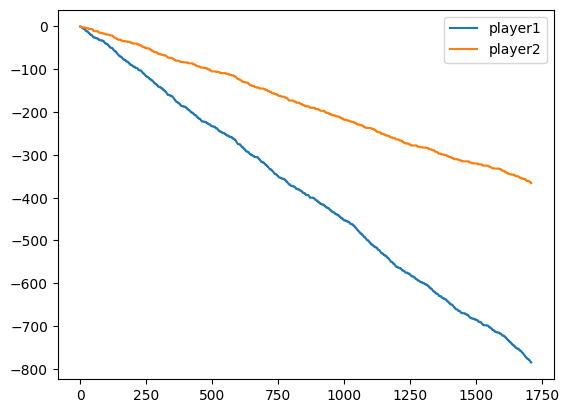

In [38]:
#@title Eval DRL

result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [39]:
#@title Load best model checkpoints

model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
if not hasattr(policy.policies[agents[0]], 'nolearn'):
    policy.policies[agents[0]].load_state_dict(torch.load(model_save_path1))
if not hasattr(policy.policies[agents[1]], 'nolearn'):
    policy.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.205
ratio of death rate of player2 with respect to player1: 0.474


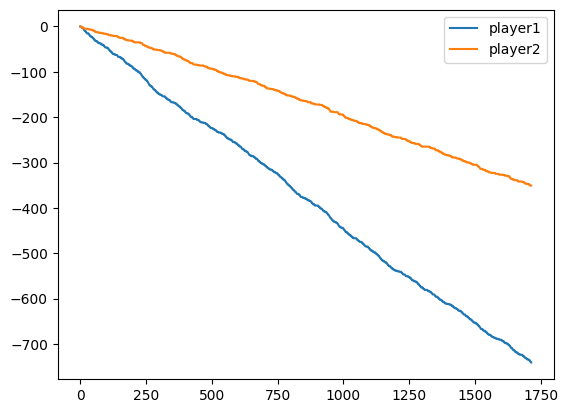

In [40]:
#@title Eval DRL
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [41]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

scaler = MinMaxScaler(feature_range=(0, 1))

df["player2_predicted_action"] = policy.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]
df["player2_logit_diff"] = scaler.fit_transform((df["player2_logit_play"] - df["player2_logit_wait"]).values[:, None])

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play,player2_logit_diff
0,1,0,0,0.2,0.2,wait,wait,play,-4.815929,-3.514331,0.631268
1,1,0,0,0.2,0.2,wait,play,play,-4.831939,-4.792096,0.449485
2,1,0,0,0.2,0.2,wait,none,wait,-4.951324,-6.090095,0.279680
3,1,0,0,0.2,0.2,play,wait,play,-4.468864,-3.159916,0.632326
4,1,0,0,0.2,0.2,play,play,play,-4.791848,-3.597631,0.615797


In [42]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

0.703125

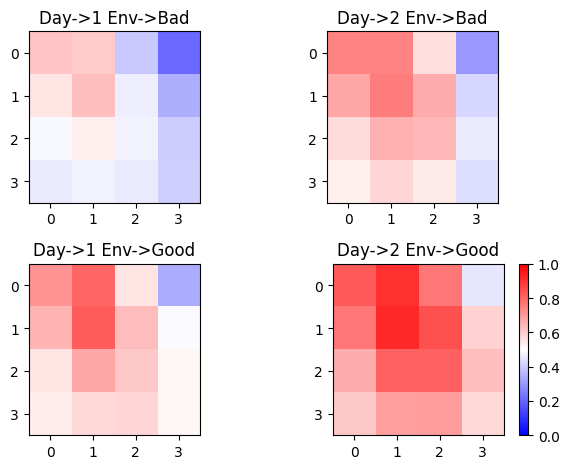

In [44]:
#@title Visualize policy
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_previous_action"] == "play") & 
    (df["player2_previous_action"] == "play"), "player2_logit_diff"
].values

ax1.imshow(np.reshape(arr, (4, 4)), cmap='bwr', vmin=0, vmax=1)
ax1.set_title("Day->1 Env->Bad")

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_previous_action"] == "play") & 
    (df["player2_previous_action"] == "play"), "player2_logit_diff"
].values

ax2.imshow(np.reshape(arr, (4, 4)), cmap='bwr', vmin=0, vmax=1)
ax2.set_title("Day->2 Env->Bad")

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_previous_action"] == "play") & 
    (df["player2_previous_action"] == "play"), "player2_logit_diff"
].values

ax3.imshow(np.reshape(arr, (4, 4)), cmap='bwr', vmin=0, vmax=1)
ax3.set_title("Day->1 Env->Good")

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_previous_action"] == "play") & 
    (df["player2_previous_action"] == "play"), "player2_logit_diff"
].values

ax = ax4.imshow(np.reshape(arr, (4, 4)), cmap='bwr', vmin=0, vmax=1)
ax4.set_title("Day->2 Env->Good")
fig.colorbar(ax, ax=ax4)

fig.tight_layout()
plt.show()

death rate of player2: 0.217
ratio of death rate of player2 with respect to player1: 0.478


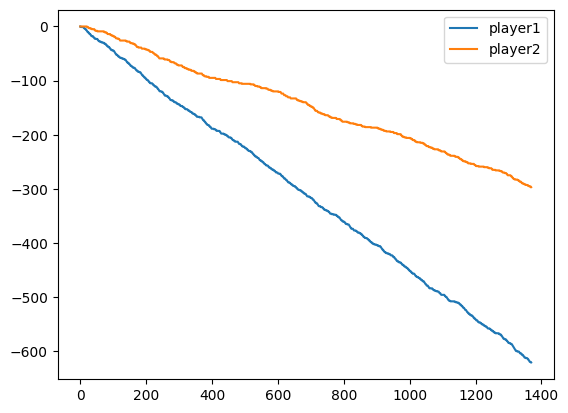

In [45]:
#@title Case - Optimal vs DRL
policy = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.207
ratio of death rate of player2 with respect to player1: 0.597


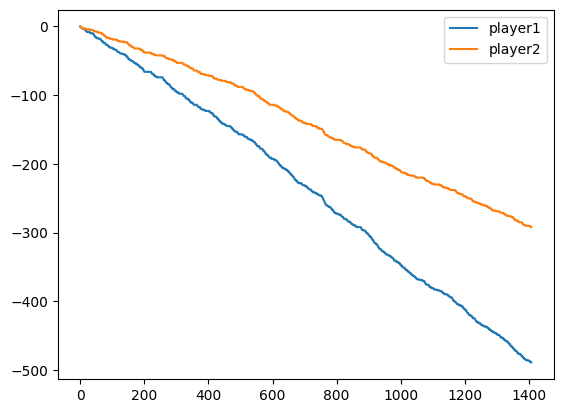

In [46]:
#@title Case - optimal vs optimal
policy = MultiAgentPolicyManager([OptimalPolicy(), OptimalPolicy()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.382
ratio of death rate of player2 with respect to player1: 0.987


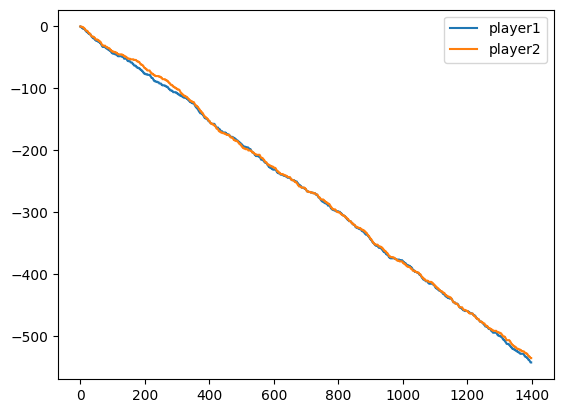

In [47]:
#@title Case - optimal vs Hail Mary
policy = MultiAgentPolicyManager([OptimalPolicy(), HailMary()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.451
ratio of death rate of player2 with respect to player1: 0.991


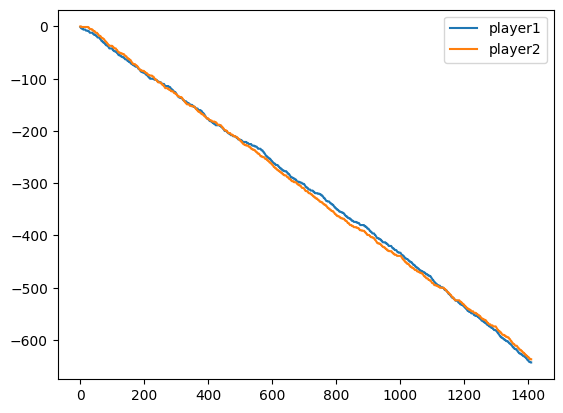

In [48]:
#@title Case - optimal vs random agent
policy = MultiAgentPolicyManager([OptimalPolicy(), RandomAgent()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()